In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import yfinance as yf
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
stocks = ["KO"]
start_date = "2000-01-01"
end_date = "2023-12-01"
stock_data_list = []

# Download S&P 500 data
sp500 = yf.download('^GSPC', start=start_date, end=end_date)
sp500 = sp500[['Close']].rename(columns={'Close': 'SP500_Close'})
for stock in stocks:
    df = yf.download(stock, start=start_date, end=end_date)
    df['Stock'] = stock
    # Merge the S&P 500 close data with the stock data on the date index
    df = df.merge(sp500, left_index=True, right_index=True, how='left')
    
    # Calculate the correlation of the stock's close with the S&P 500 close
    df['SP500_Correlation'] = df['Close'].corr(df['SP500_Close'])
    
    stock_data_list.append(df)
stock_data = pd.concat(stock_data_list)
stock_data.reset_index(inplace=True)

print(stock_data.head(-1))

# After the loop, you can drop the NaN values from the correlation calculation if needed
stock_data.dropna(subset=['SP500_Correlation'], inplace=True)
stock_data.reset_index(drop=True, inplace=True)

# checking df
null_values = stock_data.isnull().sum()
print("Null values in each column:\n", null_values)

stock_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
           Date       Open       High        Low      Close  Adj Close  \
0    2000-01-03  29.000000  29.000000  27.625000  28.187500  14.549591   
1    2000-01-04  28.187500  28.406250  27.812500  28.218750  14.565720   
2    2000-01-05  28.218750  28.718750  28.031250  28.468750  14.694763   
3    2000-01-06  28.468750  28.843750  28.281250  28.500000  14.710896   
4    2000-01-07  28.937500  30.375000  28.937500  30.375000  15.678720   
...         ...        ...        ...        ...        ...        ...   
6011 2023-11-22  58.259998  58.540001  58.130001  58.419998  57.958496   
6012 2023-11-24  58.459999  58.750000  58.340000  58.570000  58.107315   
6013 2023-11-27  58.540001  58.689999  58.270000  58.459999  57.998184   
6014 2023-11-28  58.400002  58.830002  58.360001  58.580002  58.117237   
6015 2023-11-29  58.580002  58.669998  58.099998

,Date,Open,High,Low,Close,Adj Close,Volume,Stock,SP500_Close,SP500_Correlation
0,2000-01-03,29.000000,29.000000,27.625000,28.187500,14.549591,10997000,KO,1455.219971,0.925094
1,2000-01-04,28.187500,28.406250,27.812500,28.218750,14.565720,7308000,KO,1399.420044,0.925094
2,2000-01-05,28.218750,28.718750,28.031250,28.468750,14.694763,9457400,KO,1402.109985,0.925094
3,2000-01-06,28.468750,28.843750,28.281250,28.500000,14.710896,7129200,KO,1403.449951,0.925094
4,2000-01-07,28.937500,30.375000,28.937500,30.375000,15.678720,11474000,KO,1441.469971,0.925094
...,...,...,...,...,...,...,...,...,...,...
6012,2023-11-24,58.459999,58.750000,58.340000,58.570000,58.107315,4816000,KO,4559.339844,0.925094
6013,2023-11-27,58.540001,58.689999,58.270000,58.459999,57.998184,16246500,KO,4550.430176,0.925094
6014,2023-11-28,58.400002,58.830002,58.360001,58.580002,58.117237,13739600,KO,4554.890137,0.925094
6015,2023-11-29,58.580002,58.669998,58.099998,58.230000,57.770000,11263600,KO,4550.580078,0.925094


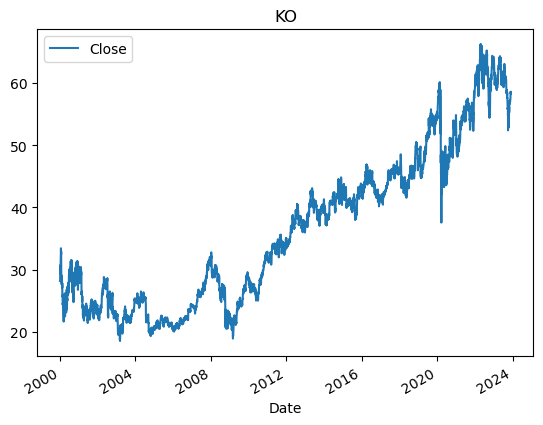

In [3]:
import matplotlib.pyplot as plt
for stock in stocks:
    stock_data[stock_data['Stock'] == stock].plot(x='Date', y='Close', title=stock)

plt.show()

In [4]:
# Convert 'Date' column to datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Set the Date as the index for decomposition
stock_data.set_index('Date', inplace=True)

In [5]:
# Time Series Decomposition of KO's Close price
decomposition = seasonal_decompose(stock_data['Close'], model='additive', period=365)  # Adjust period as needed
stock_data['Trend'] = decomposition.trend
stock_data['Seasonality'] = decomposition.seasonal
stock_data['Residual'] = decomposition.resid

In [6]:
# Handling any NaN values
stock_data.fillna(method='bfill', inplace=True)
stock_data.fillna(method='ffill', inplace=True)

C:\Users\omgai\AppData\Local\Temp\ipykernel_11992\1740433440.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='bfill', inplace=True)
C:\Users\omgai\AppData\Local\Temp\ipykernel_11992\1740433440.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


In [7]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,Stock,SP500_Close,SP500_Correlation,Trend,Seasonality,Residual
Date,,,,,,,,,,,,
2000-01-03,29.000000,29.000000,27.625000,28.187500,14.549591,10997000,KO,1455.219971,0.925094,26.995003,-0.274028,-2.041767
2000-01-04,28.187500,28.406250,27.812500,28.218750,14.565720,7308000,KO,1399.420044,0.925094,26.995003,-0.322324,-2.041767
2000-01-05,28.218750,28.718750,28.031250,28.468750,14.694763,9457400,KO,1402.109985,0.925094,26.995003,-0.292256,-2.041767
2000-01-06,28.468750,28.843750,28.281250,28.500000,14.710896,7129200,KO,1403.449951,0.925094,26.995003,-0.312332,-2.041767
2000-01-07,28.937500,30.375000,28.937500,30.375000,15.678720,11474000,KO,1441.469971,0.925094,26.995003,-0.373476,-2.041767
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,58.459999,58.750000,58.340000,58.570000,58.107315,4816000,KO,4559.339844,0.925094,60.471534,0.224079,-0.336246
2023-11-27,58.540001,58.689999,58.270000,58.459999,57.998184,16246500,KO,4550.430176,0.925094,60.471534,0.321780,-0.336246
2023-11-28,58.400002,58.830002,58.360001,58.580002,58.117237,13739600,KO,4554.890137,0.925094,60.471534,0.072513,-0.336246


In [8]:
# Selecting Features and Target for the model
features = ['SP500_Close', 'SP500_Correlation','Trend', 'Seasonality', 'Residual']
X = stock_data[features]
y = stock_data['Close']  # Target variable

In [9]:
# Calculate EMA of Close price for 'KO'
ema_span = 26  # This is the span for EMA calculation, adjust as needed
stock_data['EMA'] = stock_data['Close'].ewm(span=ema_span, adjust=False).mean()

# Adding EMA to the features
features.append('EMA')


In [10]:
features

['SP500_Close', 'SP500_Correlation', 'Trend', 'Seasonality', 'Residual', 'EMA']

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [12]:
# Splitting Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [13]:
# Define the parameter grid for Ridge Regression
param_grid_ridge = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

# Create a Ridge model for grid search
ridge_model = Ridge()

# Grid Search with Cross-Validation
grid_search_ridge = GridSearchCV(ridge_model, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search_ridge.fit(X_train, y_train)

# Best Ridge Model
best_ridge_model = grid_search_ridge.best_estimator_
print("Best Parameters for Ridge Regression:", grid_search_ridge.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ........................................

In [14]:
# Best alpha parameter obtained from grid search
best_alpha = grid_search_ridge.best_params_['alpha']

In [15]:
# Ridge Regression Model with the best parameter
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create a Random Forest model for grid search
rf_model = RandomForestRegressor(random_state=42)

# Grid Search with Cross-Validation
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_rf.fit(X_train, y_train)

# Best Random Forest Model
best_rf_model = grid_search_rf.best_estimator_
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}


In [17]:
# Best parameters obtained from grid search for Random Forest
best_params_rf = grid_search_rf.best_params_

In [18]:
# Random Forest Model with best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=42
)
best_rf_model.fit(X_train, y_train)
rf_predictions = best_rf_model.predict(X_test)

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate Ridge Model
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)
print("Ridge Regression - MSE:", ridge_mse)
print("Ridge Regression - R2:", ridge_r2)

# Evaluate Random Forest Model
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
print("Random Forest - MSE:", rf_mse)
print("Random Forest - R2:", rf_r2)

Ridge Regression - MSE: 0.6522838851950855
Ridge Regression - R2: 0.9959985245861441
Random Forest - MSE: 0.30191648928936854
Random Forest - R2: 0.9981478748190019


In [20]:
'''

def calculate_directional_accuracy(true_values, predictions):
    # Calculate the direction of the true values
    true_direction = np.sign(np.diff(true_values))
    # Calculate the direction of the predictions
    pred_direction = np.sign(np.diff(predictions))
    # Compare the directions (true vs predicted)
    correct_direction = (true_direction == pred_direction)
    # Calculate the accuracy
    accuracy = np.sum(correct_direction) / len(correct_direction)
    return accuracy

# Directional Accuracy for Ridge
ridge_dir_acc = calculate_directional_accuracy(y_test[1:], ridge_predictions[:-1])
print("Ridge Regression - Directional Accuracy:", ridge_dir_acc)

# Directional Accuracy for Random Forest
rf_dir_acc = calculate_directional_accuracy(y_test[1:], rf_predictions[:-1])
print("Random Forest - Directional Accuracy:", rf_dir_acc)


'''

'\n\ndef calculate_directional_accuracy(true_values, predictions):\n    # Calculate the direction of the true values\n    true_direction = np.sign(np.diff(true_values))\n    # Calculate the direction of the predictions\n    pred_direction = np.sign(np.diff(predictions))\n    # Compare the directions (true vs predicted)\n    correct_direction = (true_direction == pred_direction)\n    # Calculate the accuracy\n    accuracy = np.sum(correct_direction) / len(correct_direction)\n    return accuracy\n\n# Directional Accuracy for Ridge\nridge_dir_acc = calculate_directional_accuracy(y_test[1:], ridge_predictions[:-1])\nprint("Ridge Regression - Directional Accuracy:", ridge_dir_acc)\n\n# Directional Accuracy for Random Forest\nrf_dir_acc = calculate_directional_accuracy(y_test[1:], rf_predictions[:-1])\nprint("Random Forest - Directional Accuracy:", rf_dir_acc)\n\n\n'

## Bagging ensemble - Bootstrap Aggregating 

In [31]:
from sklearn.utils import resample
import numpy as np

# Assuming X_train and y_train are your training data and labels
num_models = 5  # Number of models to train in the ensemble
ridge_predictions = []
rf_predictions = []

for i in range(num_models):
    # Create a bootstrap sample of the data
    X_sample, y_sample = resample(X_train, y_train)

    # Train Ridge model
    ridge_model = Ridge(alpha=best_alpha)  # Use your best alpha from tuning
    ridge_model.fit(X_sample, y_sample)
    ridge_predictions.append(ridge_model.predict(X_test))

    # Train Random Forest model
    rf_model = RandomForestRegressor(**best_params_rf)  # Use your best parameters from tuning
    rf_model.fit(X_sample, y_sample)
    rf_predictions.append(rf_model.predict(X_test))

# Aggregate the predictions
final_ridge_predictions = np.mean(ridge_predictions, axis=0)
final_rf_predictions = np.mean(rf_predictions, axis=0)

# Optionally, you can combine the predictions from Ridge and Random Forest
final_ensemble_predictions = (final_ridge_predictions + final_rf_predictions) / 2


In [32]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Calculate MSE and R2 for Ensemble
ensemble_mse = mean_squared_error(y_test, final_ensemble_predictions)
ensemble_r2 = r2_score(y_test, final_ensemble_predictions)

print("Ensemble Model - MSE:", ensemble_mse)
print("Ensemble Model - R2:", ensemble_r2)

Ensemble Model - MSE: 0.3585772165134584
Ensemble Model - R2: 0.9978002861201786


In [37]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Parameters
num_models = 5  # Number of models in the ensemble
k_folds = 5  # Number of folds for cross-validation

# Prepare K-Fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store metrics for each fold
mse_scores_ridge = []
mse_scores_rf = []

for train_index, test_index in kf.split(X):
    # Split data into training and test for the current fold
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Initialize lists to store predictions from each model in the ensemble
    ridge_predictions_cv = []
    rf_predictions_cv = []

    # Create and train models on bootstrapped subsets
    for i in range(num_models):
        # Bootstrap sample
        X_sample, y_sample = resample(X_train_cv, y_train_cv)

        # Train Ridge model
        ridge_model = Ridge(alpha=best_alpha)  # Use the best alpha from tuning
        ridge_model.fit(X_sample, y_sample)
        ridge_predictions_cv.append(ridge_model.predict(X_test_cv))

        # Train Random Forest model
        rf_model = RandomForestRegressor(**best_params_rf)  # Use the best parameters from tuning
        rf_model.fit(X_sample, y_sample)
        rf_predictions_cv.append(rf_model.predict(X_test_cv))

    # Aggregate predictions for this fold
    final_ridge_predictions_cv = np.mean(ridge_predictions_cv, axis=0)
    final_rf_predictions_cv = np.mean(rf_predictions_cv, axis=0)

    # Evaluate and store metrics for this fold
    mse_scores_ridge.append(mean_squared_error(y_test_cv, final_ridge_predictions_cv))
    mse_scores_rf.append(mean_squared_error(y_test_cv, final_rf_predictions_cv))

# Calculate average metrics across folds
average_mse_ridge = np.mean(mse_scores_ridge)
average_mse_rf = np.mean(mse_scores_rf)

print("Average MSE for Ridge Ensemble:", average_mse_ridge)
print("Average MSE for Random Forest Ensemble:", average_mse_rf)


Average MSE for Ridge Ensemble: 0.6604250677678009
Average MSE for Random Forest Ensemble: 0.24414672650418065


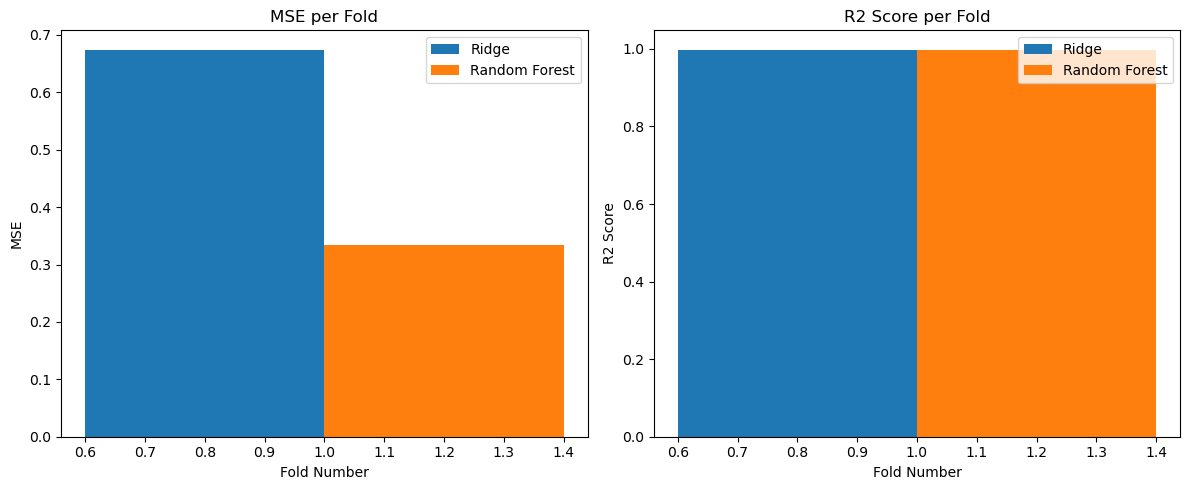

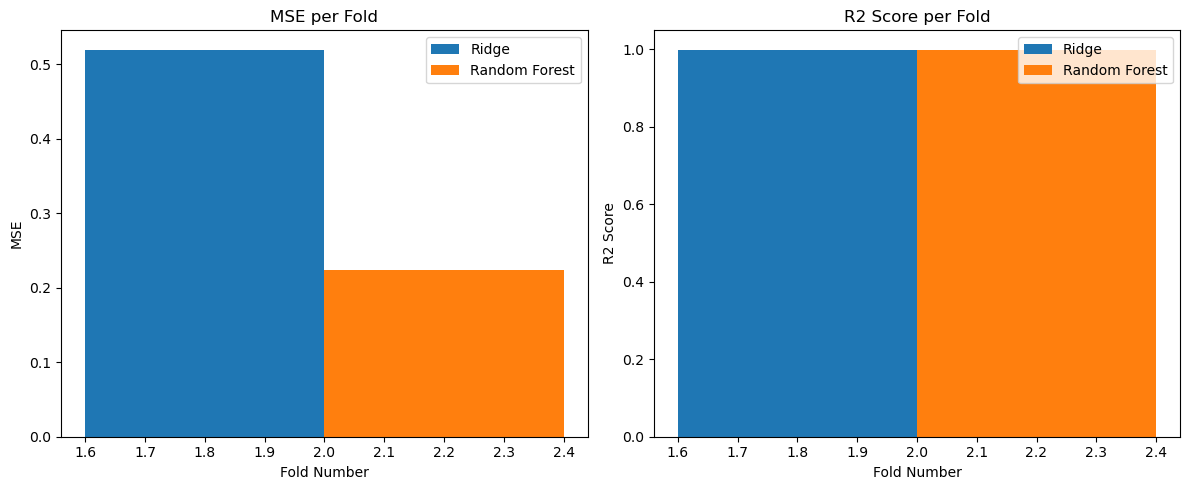

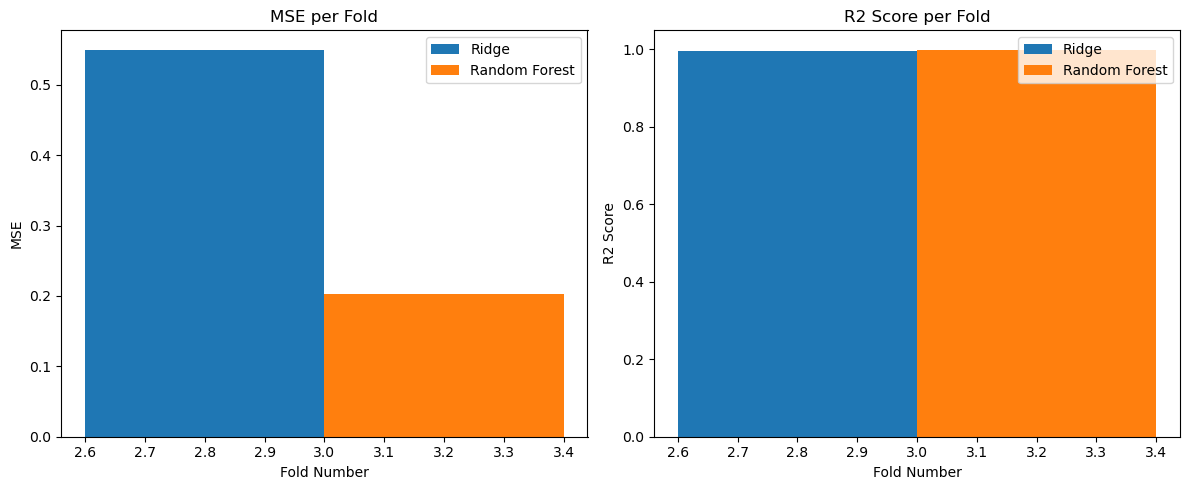

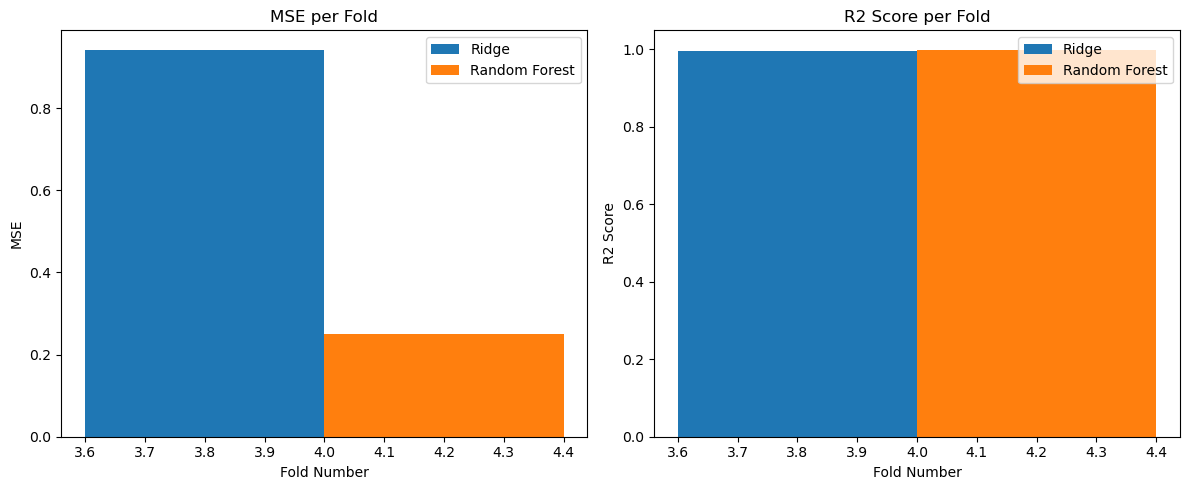

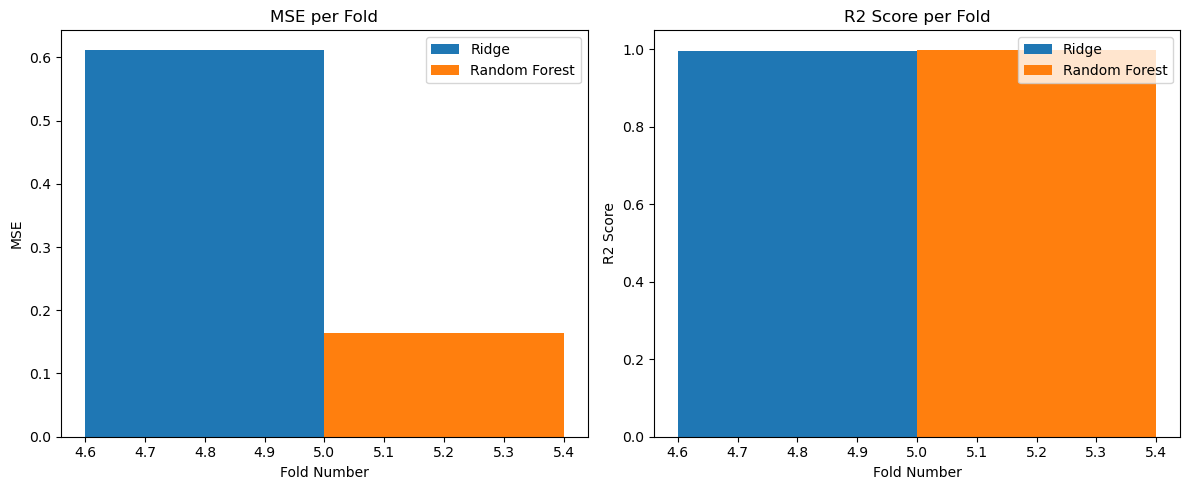

Average MSE for Ridge Ensemble: 0.6596489505154625
Average R2 for Ridge Ensemble: 0.995844550188673
Average MSE for Random Forest Ensemble: 0.23496295835626002
Average R2 for Random Forest Ensemble: 0.9985250568810828


In [38]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Initialize lists to store metrics for each fold
mse_scores_ridge = []
r2_scores_ridge = []
mse_scores_rf = []
r2_scores_rf = []

fold_number = 1

for train_index, test_index in kf.split(X):
    # Split data for this fold
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Lists for predictions from each model
    ridge_predictions_cv = []
    rf_predictions_cv = []

    for i in range(num_models):
        # Bootstrap sample
        X_sample, y_sample = resample(X_train_cv, y_train_cv)

        # Train Ridge
        ridge_model = Ridge(alpha=best_alpha)
        ridge_model.fit(X_sample, y_sample)
        ridge_predictions_cv.append(ridge_model.predict(X_test_cv))

        # Train Random Forest
        rf_model = RandomForestRegressor(**best_params_rf)
        rf_model.fit(X_sample, y_sample)
        rf_predictions_cv.append(rf_model.predict(X_test_cv))

    # Aggregate predictions
    final_ridge_predictions_cv = np.mean(ridge_predictions_cv, axis=0)
    final_rf_predictions_cv = np.mean(rf_predictions_cv, axis=0)

    # Metrics for this fold
    mse_ridge = mean_squared_error(y_test_cv, final_ridge_predictions_cv)
    r2_ridge = r2_score(y_test_cv, final_ridge_predictions_cv)
    mse_rf = mean_squared_error(y_test_cv, final_rf_predictions_cv)
    r2_rf = r2_score(y_test_cv, final_rf_predictions_cv)

    mse_scores_ridge.append(mse_ridge)
    r2_scores_ridge.append(r2_ridge)
    mse_scores_rf.append(mse_rf)
    r2_scores_rf.append(r2_rf)

    # Plotting MSE for this fold
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(fold_number - 0.2, mse_ridge, width=0.4, label='Ridge')
    plt.bar(fold_number + 0.2, mse_rf, width=0.4, label='Random Forest')
    plt.xlabel('Fold Number')
    plt.ylabel('MSE')
    plt.title('MSE per Fold')
    plt.legend()

    # Plotting R2 for this fold
    plt.subplot(1, 2, 2)
    plt.bar(fold_number - 0.2, r2_ridge, width=0.4, label='Ridge')
    plt.bar(fold_number + 0.2, r2_rf, width=0.4, label='Random Forest')
    plt.xlabel('Fold Number')
    plt.ylabel('R2 Score')
    plt.title('R2 Score per Fold')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold_number += 1

# Average metrics across all folds
print("Average MSE for Ridge Ensemble:", np.mean(mse_scores_ridge))
print("Average R2 for Ridge Ensemble:", np.mean(r2_scores_ridge))
print("Average MSE for Random Forest Ensemble:", np.mean(mse_scores_rf))
print("Average R2 for Random Forest Ensemble:", np.mean(r2_scores_rf))


In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Assuming X and y are your full dataset and labels

# Splitting data into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Train base models on the full training set
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train_full, y_train_full)

rf_model = RandomForestRegressor(**best_params_rf)
rf_model.fit(X_train_full, y_train_full)

# Generate predictions from base models on the validation set
ridge_val_predictions = ridge_model.predict(X_val)
rf_val_predictions = rf_model.predict(X_val)

# Combine predictions to form new features for the meta-model
stacked_features = np.column_stack((ridge_val_predictions, rf_val_predictions))

# Train meta-model on these new features
meta_model = LinearRegression()
meta_model.fit(stacked_features, y_val)

# Evaluate the meta-model on the test set
# First, generate base model predictions on the test set
ridge_test_predictions = ridge_model.predict(X_test)
rf_test_predictions = rf_model.predict(X_test)

# Combine base model test predictions
stacked_test_features = np.column_stack((ridge_test_predictions, rf_test_predictions))

# Meta-model predictions
meta_model_predictions = meta_model.predict(stacked_test_features)

# Evaluation
meta_mse = mean_squared_error(y_test, meta_model_predictions)
meta_r2 = r2_score(y_test, meta_model_predictions)

print("Meta-Model - MSE:", meta_mse)
print("Meta-Model - R2:", meta_r2)


Meta-Model - MSE: 0.3213511066142921
Meta-Model - R2: 0.9981007652699321
